In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
import plotly.express as px

from wordcloud import WordCloud
from autocorrect import Speller
from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [171]:
DATA_PATH = "../data/raw/youtube_comments.csv"

In [172]:
df = pd.read_csv(DATA_PATH)

In [173]:
len(df)

2527

In [174]:
df.columns

Index(['comment', 'label'], dtype='object')

In [175]:
df.head(5)

,comment,label
0,Love you sir!!,2
1,"Thank you very much, u really got me in the fi...",2
2,Another great explanation by Abdul sir. Thank ...,2
3,I had no idea what was going on in the first o...,2
4,Thankkk youuuuu soooo sooo much sir,2


In [176]:
df.label.value_counts(normalize=True)

label
2    0.408389
1    0.400871
0    0.190740
Name: proportion, dtype: float64

In [177]:
df.label.value_counts()

label
2    1032
1    1013
0     482
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

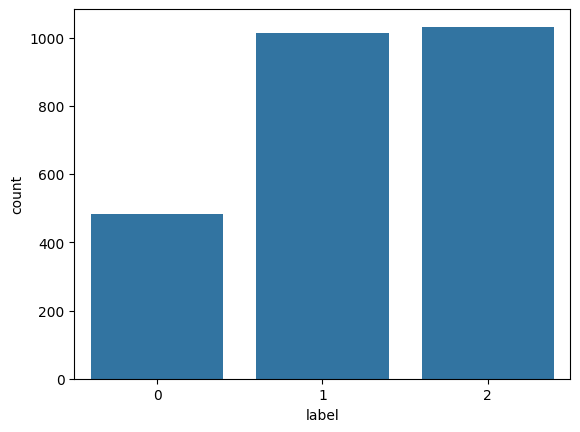

In [178]:
sns.countplot(x="label", data=df)

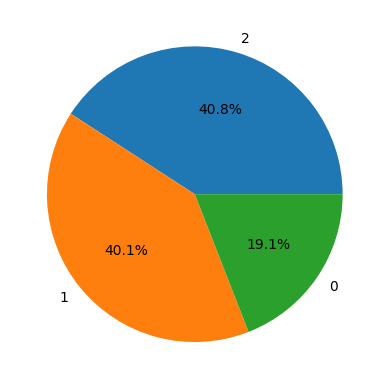

In [179]:
plt.pie(df['label'].value_counts(), labels=df['label'].unique().tolist(), autopct='%1.1f%%')
plt.show()

In [180]:
lenght = len(df['comment'][0])
print(f'Length of a sample comment: {lenght}')

Length of a sample comment: 14


In [181]:
df['length'] = df['comment'].str.len()
df.head(10)

,comment,label,length
0,Love you sir!!,2,14
1,"Thank you very much, u really got me in the fi...",2,100
2,Another great explanation by Abdul sir. Thank ...,2,58
3,I had no idea what was going on in the first o...,2,85
4,Thankkk youuuuu soooo sooo much sir,2,35
5,great job!!!!,2,13
6,Thank you Sir !!,2,16
7,Thank you so much,2,18
8,Sir you're doing really great job ..GOD may ri...,2,88
9,I love when he is wearing red because the vide...,2,71


In [182]:
word_count = df['comment'][0].split()
print(f'Word count in a sample comment: {len(word_count)}')

Word count in a sample comment: 3


In [183]:
def word_count(review):
    review_list = review.split()
    return len(review_list)
  
df['word_count'] = df['comment'].apply(word_count)
df.head(10)

,comment,label,length,word_count
0,Love you sir!!,2,14,3
1,"Thank you very much, u really got me in the fi...",2,100,18
2,Another great explanation by Abdul sir. Thank ...,2,58,10
3,I had no idea what was going on in the first o...,2,85,18
4,Thankkk youuuuu soooo sooo much sir,2,35,6
5,great job!!!!,2,13,2
6,Thank you Sir !!,2,16,4
7,Thank you so much,2,18,4
8,Sir you're doing really great job ..GOD may ri...,2,88,16
9,I love when he is wearing red because the vide...,2,71,14


In [184]:
df['mean_word_length'] = df['comment'].map(lambda rev: np.mean([len(word) for word in rev.split()]))
df.head(10)

,comment,label,length,word_count,mean_word_length
0,Love you sir!!,2,14,3,4.000000
1,"Thank you very much, u really got me in the fi...",2,100,18,4.611111
2,Another great explanation by Abdul sir. Thank ...,2,58,10,4.900000
3,I had no idea what was going on in the first o...,2,85,18,3.777778
4,Thankkk youuuuu soooo sooo much sir,2,35,6,5.000000
5,great job!!!!,2,13,2,6.000000
6,Thank you Sir !!,2,16,4,3.250000
7,Thank you so much,2,18,4,3.500000
8,Sir you're doing really great job ..GOD may ri...,2,88,16,4.562500
9,I love when he is wearing red because the vide...,2,71,14,4.142857


['length', 'word_count', 'mean_word_length']


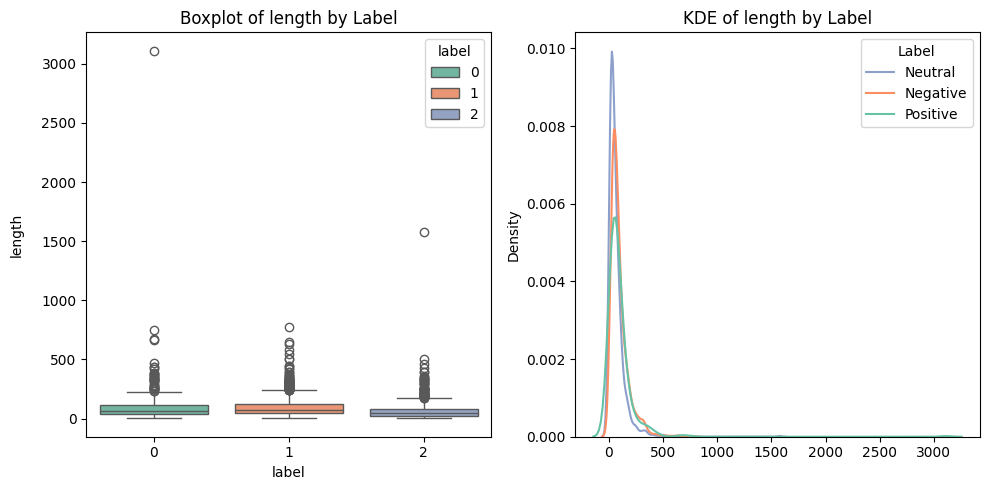

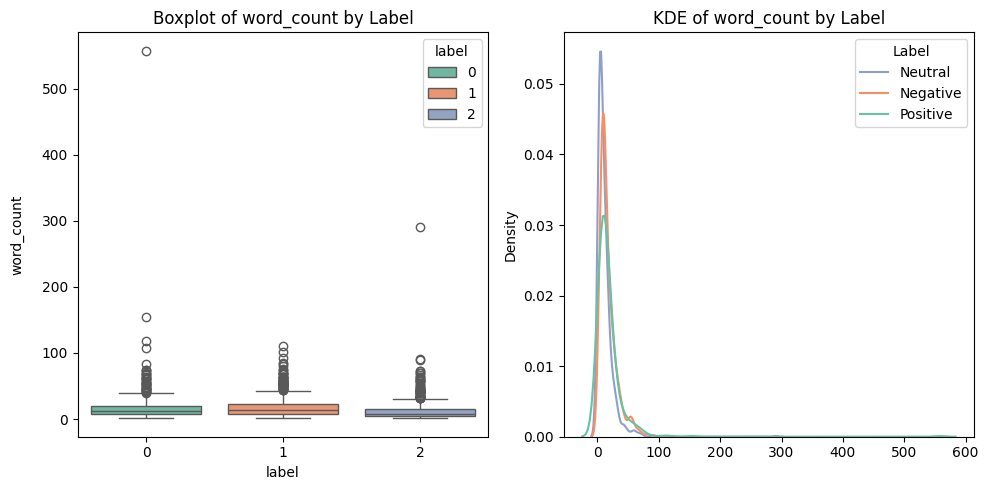

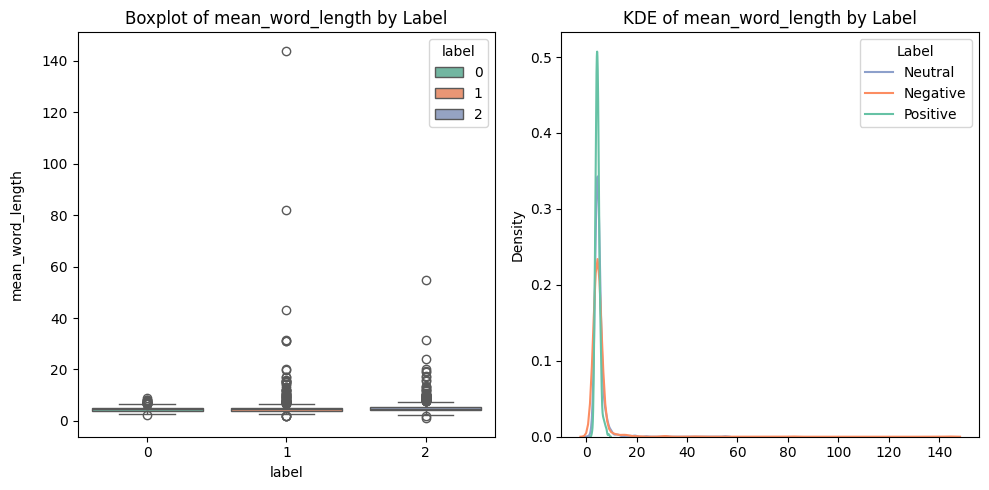

In [185]:
def visualize(col, df):
    # Ensure 'label' is categorical, in case it's numeric (optional step)
    df['label'] = df['label'].astype('category')

    # Set up the subplots
    plt.figure(figsize=(10, 5))

    # Boxplot for the numerical feature
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df['label'], y=df[col], hue=df['label'], palette="Set2")
    plt.ylabel(col, labelpad=12.5)
    plt.title(f'Boxplot of {col} by Label')

    # KDE plot (Kernel Density Estimation)
    plt.subplot(1, 2, 2)
    sns.kdeplot(data=df, x=col, hue='label', common_norm=False, palette="Set2")
    plt.legend(title='Label', labels=['Neutral', 'Negative', 'Positive'])
    plt.xlabel('')
    plt.ylabel('Density')
    plt.title(f'KDE of {col} by Label')
    
    plt.tight_layout()
    plt.show()

features = df.columns.tolist()[2:]
print(features)
for feature in features:
    visualize(feature, df)

In [186]:
df = df.drop(features, axis=1)
df.head()

,comment,label
0,Love you sir!!,2
1,"Thank you very much, u really got me in the fi...",2
2,Another great explanation by Abdul sir. Thank ...,2
3,I had no idea what was going on in the first o...,2
4,Thankkk youuuuu soooo sooo much sir,2


In [187]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2527 entries, 0 to 2526
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   comment  2527 non-null   object  
 1   label    2527 non-null   category
dtypes: category(1), object(1)
memory usage: 22.5+ KB


In [188]:
def process(comment):
    
    comment = comment.lower()
    comment = re.sub('[^a-z A-Z 0-9-]+', '', comment)
    comment = " ".join([word for word in comment.split() if word not in stopwords.words('english')])
    
    
    spell = Speller(lang="en")
    comment = spell(comment)
    
    stemmer = nltk.stem.SnowballStemmer('english')
    comment = stemmer.stem(comment)
    
    lemmatizer = nltk.stem.WordNetLemmatizer()
    comment = lemmatizer.lemmatize(comment)
    
    return comment

In [189]:
df['comment'] = df['comment'].apply(process)
df.head(10)

,comment,label
0,love sir,2
1,thank much u really got first video algorithm ...,2
2,another great explanation abdul sir thank much,2
3,idea going first one one cleared everyth,2
4,thanks youuuuu soon soon much sir,2
5,great job,2
6,thank sir,2
7,thank much,2
8,sir youre really great job god may richly bles...,2
9,love wearing red video updated brilli,2


In [190]:
def corpus(text):
  text_list = text.split()
  return text_list

df['comment_lists'] = df['comment'].apply(corpus)
df.head(10)

,comment,label,comment_lists
0,love sir,2,"[love, sir]"
1,thank much u really got first video algorithm ...,2,"[thank, much, u, really, got, first, video, al..."
2,another great explanation abdul sir thank much,2,"[another, great, explanation, abdul, sir, than..."
3,idea going first one one cleared everyth,2,"[idea, going, first, one, one, cleared, everyth]"
4,thanks youuuuu soon soon much sir,2,"[thanks, youuuuu, soon, soon, much, sir]"
5,great job,2,"[great, job]"
6,thank sir,2,"[thank, sir]"
7,thank much,2,"[thank, much]"
8,sir youre really great job god may richly bles...,2,"[sir, youre, really, great, job, god, may, ric..."
9,love wearing red video updated brilli,2,"[love, wearing, red, video, updated, brilli]"


In [191]:
corpus = []
for i in trange(df.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpus += df['comment_lists'][i]
len(corpus)

  0%|                                                                                                                        | 0/2527 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2527/2527 [00:00<00:00, 72841.40it/s]


21295

In [192]:
mostCommon = Counter(corpus).most_common(10)
mostCommon

[('sir', 643),
 ('thank', 344),
 ('video', 326),
 ('java', 285),
 ('please', 208),
 ('much', 200),
 ('thanks', 160),
 ('u', 144),
 ('videos', 142),
 ('great', 126)]

In [193]:
words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)

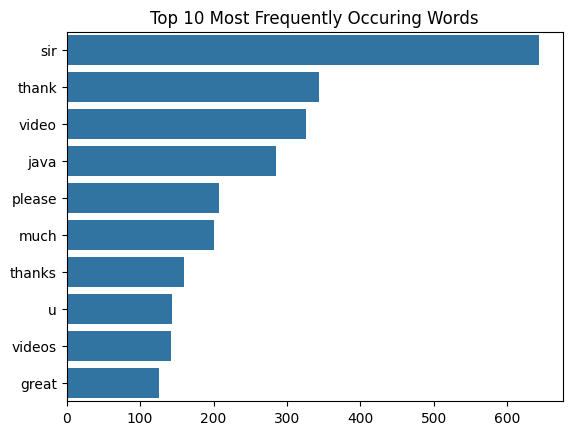

In [194]:
sns.barplot(x=freq, y=words)
plt.title('Top 10 Most Frequently Occuring Words')
plt.show()

In [195]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(df['comment'])

In [196]:
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

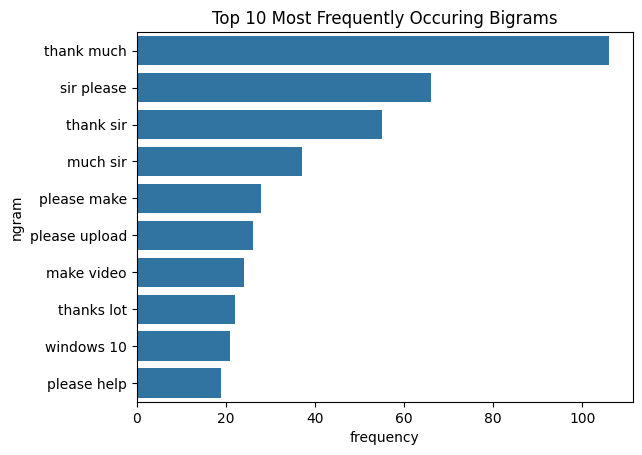

In [197]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

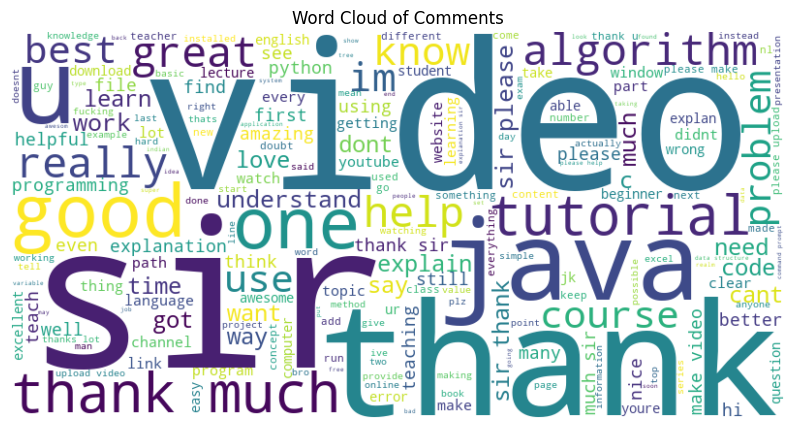

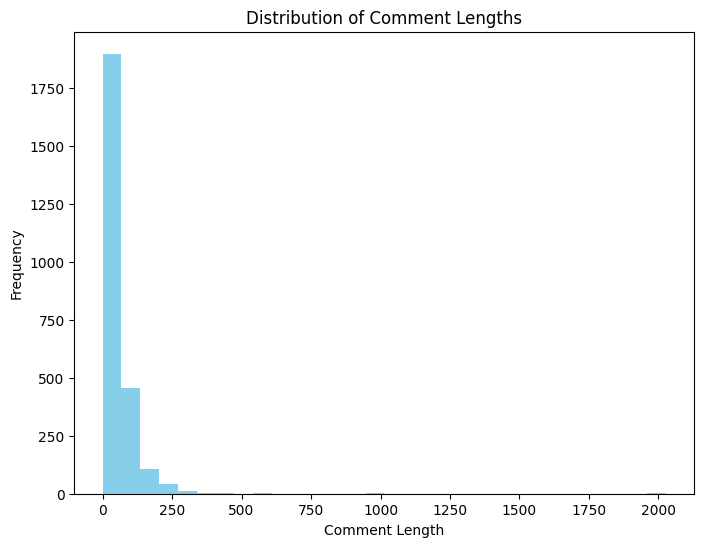

In [198]:
# Concatenate all comments into a single string
comments_text = ' '.join(df['comment'].values)
# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments_text)
# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Comments')
plt.show()

# Histogram to visualize the length of comments
comment_lengths = df['comment'].str.len()

plt.figure(figsize=(8, 6))
plt.hist(comment_lengths, bins=30, color='skyblue')
plt.title('Distribution of Comment Lengths')
plt.xlabel('Comment Length')
plt.ylabel('Frequency')
plt.show()

In [199]:
df["comment_lists"]

0                                             [love, sir]
1       [thank, much, u, really, got, first, video, al...
2       [another, great, explanation, abdul, sir, than...
3        [idea, going, first, one, one, cleared, everyth]
4                [thanks, youuuuu, soon, soon, much, sir]
                              ...                        
2522    [practise, practise, practise, couldnt, agree,...
2523    [need, small, hep, gre, 3, days, bad, rc, stre...
2524                                [failed, last, quest]
2525    [thats, true, the, happen, first, thing, said,...
2526                         [video, working, 31, second]
Name: comment_lists, Length: 2527, dtype: object

In [200]:
df.drop("comment_lists", axis=1, inplace=True)

In [201]:
df.head(10)

,comment,label
0,love sir,2
1,thank much u really got first video algorithm ...,2
2,another great explanation abdul sir thank much,2
3,idea going first one one cleared everyth,2
4,thanks youuuuu soon soon much sir,2
5,great job,2
6,thank sir,2
7,thank much,2
8,sir youre really great job god may richly bles...,2
9,love wearing red video updated brilli,2


In [202]:
df.to_csv("../data/processed/processed_data.csv", index=False)